# <center> The D-ACO/IDS Project <br>
## <center> (Digital - Ant Colony Optimization/Intrusion Detection System)
### <center> Classification

In [1]:
import findspark
findspark.init()

In [2]:
# Importação de modulos Python
import os
import time
from datetime import datetime

import numpy as np
import pandas as pd

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

import pyspark.pandas as ps
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
#from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import feature

from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.feature import VectorAssembler, VectorIndexer

from pyspark.ml.clustering import LDA
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.linalg import Vectors
from pyspark.mllib.util import MLUtils

In [4]:
# Importação da biblioteca Scipy
from scipy import stats

In [5]:
# Importação das bibliotecas Graficas
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

# Exibe gráficos na página (inline)
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
seed = 123 # Fixar a semente aleatória dos algoritmos

## Classificação e Avaliação - Apache Spark

In [8]:
spark = SparkSession.builder\
       .appName("D-ACO/IDS_SPARK")\
       .master("spark://192.168.1.20:7077") \
       .getOrCreate()

# Spark Local
#spark = SparkSession.builder \
#        .master("local[*]") \
#        .appName("Nome_do_Projeto") \
#        .config("spark.driver.maxResultSize", "2000m") \
#        .config('spark.sql.debug.maxToStringFields', 2000) \
#        .getOrCreate()

23/10/23 12:14:28 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Seleção e Apresentação do Dataset

In [9]:
df = ps.read_csv('../../../datasets/dacoids/botNeTIoT/bestsub/BotNeTIoT_L01_2023_10_23_10_53_00_selected.csv')
df.head()

,HH_L0_1_magnitude,MI_dir_L0_1_weight,HpHp_L0_1_mean,HH_jit_L0_1_mean,HH_L0_1_std,HH_L0_1_covariance,HpHp_L0_1_std,HpHp_L0_1_weight,HpHp_L0_1_pcc,HpHp_L0_1_radius,HpHp_L0_1_covariance,HH_jit_L0_1_variance,HH_L0_1_pcc,HH_L0_1_radius,label
0,98.000000,1.000000,98.0,1.505914e+09,0.000000e+00,0.0,0.000000,1.00000,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0
1,138.592929,1.931640,98.0,7.263102e+08,1.348699e-06,0.0,0.000001,1.93164,0.0,1.818989e-12,0.0,5.662344e+17,0.0,1.818989e-12,0
2,114.856432,2.904273,66.0,1.505914e+09,0.000000e+00,0.0,0.000000,1.00000,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0
3,74.000000,3.902546,74.0,1.505914e+09,0.000000e+00,0.0,0.000000,1.00000,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0
4,74.000000,4.902545,74.0,7.529571e+08,9.536743e-07,0.0,0.000000,1.00000,0.0,0.000000e+00,0.0,5.669445e+17,0.0,9.094947e-13,0


In [10]:
# Start algorithms time
start_time = time.time()

In [11]:
df_spark = df.to_spark()

In [12]:
vecAssembler = VectorAssembler(inputCols=df_spark.columns[:-1], 
                               outputCol='features')

df_spark = vecAssembler.transform(df_spark)
df_spark = df_spark.select("label","features")

#df_spark.show(5, truncate=True)

In [13]:
mmScaler = feature.MinMaxScaler(inputCol='features', 
                                outputCol='scaled_features').fit(df_spark)

df_spark = mmScaler.transform(df_spark).drop('features')
df_spark = df_spark.withColumnRenamed('scaled_features', 'features')

#df_spark.show(5, truncate=True)

In [14]:
# Split ramdomly the dataset into train and test group
# [0.7,0.3] => 70% for train and 30% for test
# [1.0,0.2] => 100% for train and 20% for test, not good, acuracy always 100%
# [0.1,0.02] => 10% for train and 2% for test, if big datasets
# 1234 is the random seed

# Sample of train and test dataset
train_sample = 0.7
test_sample = 0.3

(trainingData, testData) = df_spark.randomSplit([train_sample, test_sample], seed=1234)

In [15]:
# Dicionário de resultados
dic = {}

### Treinando e avaliando com Regressão Logística 

In [16]:
start_time_lr =  time.time()

# Train a Logistic regression
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Fit the model
model_lr = lr.fit(trainingData)

# Make predictions.
pred_lr = model_lr.transform(testData)

23/10/23 12:14:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [17]:
# Compute accuracy on the test set against model and select (prediction, true label) and compute test error
eval_lr = MulticlassClassificationEvaluator(labelCol="label", 
                                            predictionCol="prediction",
                                            metricName="accuracy")

acc_lr = eval_lr.evaluate(pred_lr)
print("Test Error = %g " % (1.0 - acc_lr))

acc_lr = acc_lr * 100

dic["Regressão\nLogistica"]  = acc_lr
time_lr = time.time() - start_time_lr

print("Regressão Logistica: accuracia = %3.1f %%" % acc_lr)
print("Regressão Logistica: tempo = %3.3f s" % time_lr)

Test Error = 0.211822 
Regressão Logistica: accuracia = 78.8 %
Regressão Logistica: tempo = 121.300 s


In [18]:
# print("Logistic Regression Final Result")
# predictions.show(5)

### Treinando e avaliando com Árvore de Decisão

In [19]:
start_time_dt =  time.time()

# Train a DecisionTree model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability', \
                            rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, \
                            maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', seed=None)

# Train model
model_dt = dt.fit(trainingData)

# Make predictions.
pred_dt = model_dt.transform(testData)

In [20]:
# Compute accuracy on the test set against model and select (prediction, true label) and compute test error
eval_dt = MulticlassClassificationEvaluator(labelCol="label", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

acc_dt = eval_dt.evaluate(pred_dt)
print("Test Error = %g " % (1.0 - acc_dt))

acc_dt = acc_dt * 100

dic['Árvore de\nDecisão']  = acc_dt
time_dt = time.time() - start_time_dt

print("Árvore de Decisão: acuracia = %3.1f %%" % acc_dt)
print("Árvore de Decisão: tempo = %3.3f s" % time_dt)

Test Error = 0.000461943 
Árvore de Decisão: acuracia = 100.0 %
Árvore de Decisão: tempo = 16.300 s


In [21]:
# print("Decision Tree Final Result")
# predictions.show(5)

### Treinando e avaliando com Random Forest

In [22]:
start_time_rf =  time.time()

# Train a Random Forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 numTrees=50, featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini')

# Train model
model_rf = rf.fit(trainingData)

# Make predictions.
pred_rf = model_rf.transform(testData)

In [23]:
# Compute accuracy on the test set against model and select (prediction, true label) and compute test error
eval_rf = MulticlassClassificationEvaluator(labelCol="label", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

acc_rf = eval_rf.evaluate(pred_rf)
print("Test Error = %g " % (1.0 - acc_rf))

acc_rf = acc_rf * 100

dic['Random\nForest']  = acc_rf
time_rf = time.time() - start_time_rf

print("Decision Tree: accuracy = %3.1f %%" % acc_rf)
print("Decision Tree: time = %3.3f s" % time_rf)

Test Error = 0.000758907 
Decision Tree: accuracy = 99.9 %
Decision Tree: time = 16.589 s


### Treinando e avaliando com Naive Bayes

In [24]:
start_time_nb =  time.time()

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# Train model
model_nb = nb.fit(trainingData)

# Make predictions.
pred_nb = model_nb.transform(testData)

In [25]:
# Compute accuracy on the test set against model and select (prediction, true label) and compute test error
eval_nb = MulticlassClassificationEvaluator(labelCol="label", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

acc_nb = eval_nb.evaluate(pred_nb)
print("Test Error = %g " % (1.0 - acc_nb))

acc_nb = acc_nb * 100

dic["Naive\nBayes"]  = acc_nb
time_nb = time.time() - start_time_nb

print("Naive Bayes: accuracia = %3.1f %%" % acc_nb)
print("Naive Bayes: tempo = %3.3f s" % time_nb)

Test Error = 0.172517 
Naive Bayes: accuracia = 82.7 %
Naive Bayes: tempo = 6.872 s


### Treinando e avaliando com Suport Vector Machines (SVM)

In [26]:
start_time_svm =  time.time()

# create the trainer and set its parameters
svm = LinearSVC(featuresCol='features', labelCol='label', maxIter=10, regParam=0.1)

# train the multiclass model.
model_svm = svm.fit(trainingData)

# score the model on test data.
pred_svm = model_svm.transform(testData)

In [27]:
# Compute accuracy on the test set against model and select (prediction, true label) and compute test error
eval_svm = MulticlassClassificationEvaluator(labelCol="label", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

acc_svm = eval_svm.evaluate(pred_svm)
print("Test Error = %g " % (1.0 - acc_svm))

acc_svm = acc_svm * 100

dic["SVM"]  = acc_svm
time_svm = time.time() - start_time_svm

print("SVM: accuracia = %3.1f %%" % acc_svm)
print("SVM: tempo = %3.3f s" % time_svm)

# https://www.kaggle.com/code/shrutimechlearn/pyspark-part-3-classification-modelling-dtree
# https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-support-vector-machine
# https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html

Test Error = 0.00533572 
SVM: accuracia = 99.5 %
SVM: tempo = 105.529 s


In [28]:
validation = pd.Series(dic, name="Acurácia")
validation

Regressão\nLogistica    78.817838
Árvore de\nDecisão      99.953806
Random\nForest          99.924109
Naive\nBayes            82.748343
SVM                     99.466428
Name: Acurácia, dtype: float64

[Text(0, 0, '78.8178'),
 Text(0, 0, '99.9538'),
 Text(0, 0, '99.9241'),
 Text(0, 0, '82.7483'),
 Text(0, 0, '99.4664')]

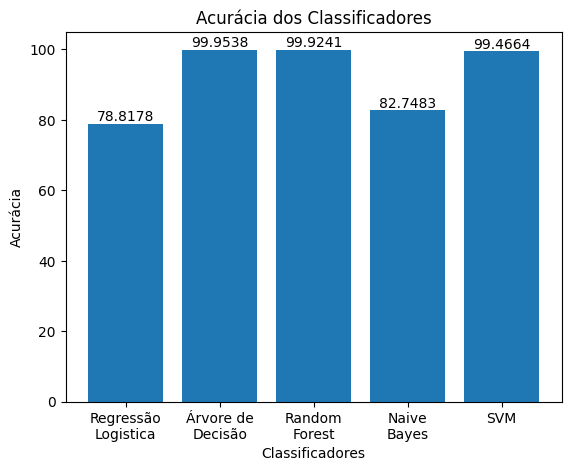

In [29]:
classificadores = dic.keys()
acc = dic.values()

fig, ax = plt.subplots()
bar_container = ax.bar(classificadores, acc)
#ax.set(ylabel='Acurácia', xlabel='Classificadores', title='Acurácia dos Classificadores', ylim=(0, 1.1))
ax.set(ylabel='Acurácia', xlabel='Classificadores', title='Acurácia dos Classificadores')
ax.bar_label(bar_container, fmt='{:,.4f}')

In [30]:
# Contabiliza o tempo de execução do algoritmo
tempo_total = (time.time() - start_time)
print(f'--- Tempo de execução: {tempo_total:.2f} segundos ---')

--- Tempo de execução: 272.39 segundos ---


In [31]:
# Stop Spark session
spark.stop()